In [1]:
import gc

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_raw = pd.read_parquet('/home/sarath/uob/git/amex-default-prediction/data/processed/train.parquet')

In [3]:
train_raw.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 190 columns):
 #    Column       Non-Null Count    Dtype  
---   ------       --------------    -----  
 0    customer_ID  5531451 non-null  object 
 1    S_2          5531451 non-null  object 
 2    P_2          5485466 non-null  float32
 3    D_39         5531451 non-null  int16  
 4    B_1          5531451 non-null  float32
 5    B_2          5529435 non-null  float32
 6    R_1          5531451 non-null  float32
 7    S_3          4510907 non-null  float32
 8    D_41         5529435 non-null  float32
 9    B_3          5529435 non-null  float32
 10   D_42         791314 non-null   float32
 11   D_43         3873055 non-null  float32
 12   D_44         5531451 non-null  int8   
 13   B_4          5531451 non-null  int16  
 14   D_45         5529434 non-null  float32
 15   B_5          5531451 non-null  float32
 16   R_2          5531451 non-null  int8   
 17   D_46         4319752 non-

In [4]:
train_raw.head(3)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0


<AxesSubplot:xlabel='S_2', ylabel='count'>

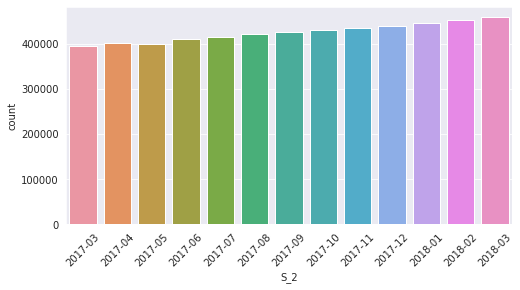

In [5]:
train_raw["S_2"] = pd.to_datetime(train_raw["S_2"])
statement_date_group = train_raw.groupby(train_raw.S_2.dt.to_period('M')).size()
statement_date_group_df = pd.DataFrame(statement_date_group.to_frame())
statement_date_group_df.columns=['count']
plt.figure(figsize=(8, 4))
plt.xticks(rotation=45)
sns.barplot(x = statement_date_group_df.index, y = 'count' , data=statement_date_group_df)

In [6]:
train_raw['S_3'].describe()

count    4.510907e+06
mean     2.258454e-01
std      1.933475e-01
min     -6.271321e-01
25%      1.272588e-01
50%      1.639082e-01
75%      2.581017e-01
max      5.482888e+00
Name: S_3, dtype: float64

(-0.5, 1.5)

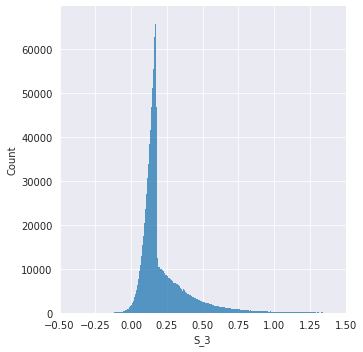

In [7]:
sns.displot(x='S_3', data=train_raw)
plt.xlim(-0.5, 1.5)

In [ ]:
for i in range(3, 10, 1):
    col = 'S_'+ str(i)
    if col in train_raw.columns:
        print('Preparing distribution chart for %s'.format(col))
        sns.displot(x=col, data=train_raw)
